## Import Required Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os, datetime
from matplotlib import pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

## Import Dataset and Create DataLoader

In [2]:
train_df = pd.read_csv("../split_datasets/train.csv")[0:10000]
train_df = train_df.drop(columns="id")
train_df = train_df.drop(columns="last_scraped")
train_df = train_df.drop(columns="amenities")

val_df = pd.read_csv("../split_datasets/val.csv")[0:1000]
val_df = val_df.drop(columns="id")
val_df = val_df.drop(columns="last_scraped")
val_df = val_df.drop(columns="amenities")

test_df = pd.read_csv("../split_datasets/test.csv")[0:1000]
test_df = test_df.drop(columns="id")
test_df = test_df.drop(columns="last_scraped")
test_df = test_df.drop(columns="amenities")

In [3]:
class airbnb_dataset (Dataset):
    def __init__(self, df, purpose):
        self.df = df
        self.price = self.df["price"]
        self.df = self.df.drop(columns="price")
        self.purpose = purpose
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        # Returns specific sample as a dict
        if torch.is_tensor(index):
            index = index.tolist()
        sample = torch.tensor(np.array(self.df.iloc[index]))
        label = torch.tensor(np.array([self.price.iloc[index]]))
        return {"sample": sample, "label": label}
    
train_ds = airbnb_dataset(train_df, "train")
val_ds = airbnb_dataset(val_df, "val")
test_ds = airbnb_dataset(test_df, "test")

train_loader = DataLoader(train_ds, batch_size=1000, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1000, shuffle=False, num_workers=4)

#### Visualize Data Samples

In [4]:
pd.set_option('display.max_columns', None)
train_df.head(5)

,host_is_superhost,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,instant_bookable,cancellation_policy,amenities_Kitchen,amenities_Heating,amenities_Washer,amenities_Wifi,amenities_Indoor fireplace,amenities_Iron,amenities_Laptop friendly workspace,amenities_Crib,amenities_Self check-in,amenities_Carbon monoxide detector,amenities_Shampoo,amenities_Air conditioning,amenities_Dryer,amenities_Breakfast,amenities_Hangers,amenities_Hair dryer,amenities_TV,amenities_High chair,amenities_Smoke detector,amenities_Private bathroom,amenities_count,facilities_Free parking on premises,facilities_Gym,facilities_Hot tub,facilities_Pool,facilities_count,house_rules_Suitable for events,house_rules_Pets allowed,house_rules_Smoking allowed,house_rules_count
0,0,-0.396491,0.215068,-0.444532,-0.686927,-0.597957,-0.436242,-0.353343,-0.650700,0.438466,0,1.160642,1,1,1,1,0,1,1,0,0,0,1,1,1,1,0,1,1,0,1,0,0.293298,0,1,1,1,1.638226,0,0,0,-0.410572
1,0,-0.841516,0.095963,1.182045,-0.686927,-0.597957,-0.436242,-0.353343,-0.650700,2.623250,0,-1.125796,1,1,1,1,0,1,1,0,0,0,1,1,1,0,1,1,1,0,1,0,0.293298,0,1,0,1,0.791537,0,0,0,-0.410572
2,0,-0.725178,-0.909397,-0.444532,1.329375,-0.597957,-0.436242,-0.353343,-0.650700,-1.027833,1,-1.125796,1,1,1,1,0,0,0,0,0,0,1,1,1,0,0,0,1,0,1,0,-1.147823,0,0,0,0,-0.901841,0,0,0,-0.410572
3,0,-0.048882,0.086232,-0.444532,-0.686927,-0.597957,-0.436242,-1.660357,-0.650700,1.171615,0,-0.422277,1,1,1,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,-1.147823,1,0,0,1,0.791537,0,0,0,-0.410572
4,0,-0.635052,0.094278,-0.444532,-0.686927,-0.030463,-0.436242,0.953672,0.389812,1.010322,0,1.160642,1,1,1,1,0,1,1,0,0,1,0,1,1,0,1,1,1,0,1,0,0.293298,0,1,0,0,-0.055152,0,1,0,1.813424


#### Import Mean and Std File

In [5]:
mean_std = pd.read_csv("../data_processing/mean_std.csv", index_col=0)
mean_std

,mean,std
price,120.097102,68.198942
latitude,43.677492,0.046110
longitude,-79.398326,0.059359
property_type,2.819879,1.844364
room_type,0.340686,0.495957
accommodates,3.053679,1.762132
bathrooms,1.200374,0.459320
bedrooms,1.270343,0.765102
beds,1.625366,0.961066
cancellation_policy,7.400940,5.685699


## Define Model

In [6]:
class airbnb_net (nn.Module):
    def __init__(self):
        super(airbnb_net, self).__init__()
        self.layer1 = nn.Linear(41, 41*2)
        self.layer2 = nn.Linear(41*2, 41*2)
        self.layer3 = nn.Linear(41*2, 41*1)
        self.layer4 = nn.Linear(41*1, 1)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        return self.layer4(x)

## Training Function

In [7]:
def train(net, train_loader, val_loader, folder, lr, num_epoch):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    print("Starting Training...")
    start_time = time.time()
    epochs, losses = [], []
    epochs2, train_error, val_error, train_acc, val_acc = [], [], [], [[],[],[]], [[],[],[]]
    
    for epoch in range(num_epoch):
        epoch_loss = 0
        epoch_time = time.time()
        batch_loss = 0
        batch_time = time.time()
        for i, data in enumerate(train_loader):
            sample = data["sample"].float()
            label = data["label"].float()
            output = net(sample)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            batch_loss += loss.item()
            epoch_loss += loss.item()
            if i % 10 == 9:
                batch_loss = batch_loss/10
                print("---[ITER %d] loss: %.6f  time: %.3f" % (i+1, batch_loss, time.time()-batch_time))
                batch_loss = 0
                batch_time = time.time()
        epoch_loss /= len(train_loader)
        
        # Record Loss
        epochs.append(epoch)
        losses.append(epoch_loss)
        
        # Record Error, Accuracy 
        if epoch % 10 == 9:
            epochs2.append(epoch)
            avg_train_error, avg_train_acc, avg_val_error, avg_val_acc = get_error(net, train_loader, val_loader, [10, 20, 30])
            train_error.append(avg_train_error)
            val_error.append(avg_val_error)
            for i in range(3):
                train_acc[i].append(avg_train_acc[i])
                val_acc[i].append(avg_val_acc[i])
                
            torch.save({
                    'epoch' : epoch,
                    'model_state_dict' : net.state_dict(),
                    'optimizer_state_dict' : optimizer.state_dict(),
                    'epochs' : epochs,
                    'losses' : losses,
                    'epochs2': epochs2,
                    'train_error': train_error,
                    'train_acc': train_acc,
                    'val_error': val_error,
                    'val_acc' : val_acc,
                    'lr' : lr
                }, folder+"/checkpoint/checkpoint_"+'{:04d}'.format(epoch)+".tar")
        
        print("[EPOCH %d] loss: %.6f  time: %.3f" % (epoch+1, epoch_loss, time.time()-epoch_time))
        
        if epoch % 10 == 9:
            plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=False)

    print("=========================================")
    print("Training Completed...")
    print("[FINAL] loss: %.6f  time: %.3f" % (epoch_loss, time.time()-start_time))
          
    # plot loss, error, accuracy
    plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=True)
    
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : net.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        'epochs' : epochs,
        'losses' : losses,
        'epochs2': epochs2,
        'train_error': train_error,
        'train_acc': train_acc,
        'val_error': val_error,
        'val_acc' : val_acc,
        'lr' : lr
    }, folder+"/final/checkpoint_final.tar")

## Plotting Function

In [8]:
def plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last = False):
    # plot loss curve
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    if last == False:
        plt.savefig(folder+"/lossplot/lossplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/lossplot_final.png", dpi=150)
    plt.show()
    plt.close()
    
    # plot error curve
    plt.title("Training Error Curve")
    plt.plot(epochs2, train_error, label="Train")
    plt.plot(epochs2, val_error, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Absolute Error (in $)")
    plt.legend(loc='best')

    if last == False:
        plt.savefig(folder+"/errorplot/errorplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/errorplot_final.png", dpi=150)
    plt.show()
    plt.close()

    # plot accuracy curve
    plt.title("Training Accuracy Curve")
    for i in range(3):
        plt.plot(epochs2, train_acc[i], label="Train - Thresh: "+str(i*10+10))
        plt.plot(epochs2, val_acc[i], label="Validation - Thresh: "+str(i*10+10))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    
    if last == False:
        plt.savefig(folder+"/accplot/accplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/accplot_final.png", dpi=150)
    
    plt.show()
    plt.close()

    return None

## Error Calculation Function

In [9]:
def get_error(model, train_loader, val_loader, threshold):
    train_samples = 0
    train_error = 0
    train_accuracy = [0 for i in threshold]
    for i, data in enumerate(train_loader):
        sample = data["sample"].float()
        label = data["label"].float()
        output = net(sample)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            train_accuracy[j] += accurate.sum().item()
        train_samples += len(label)
        train_error += error.sum().item()
    avg_train_error = float(train_error)/float(train_samples)
    avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]
    
    val_samples = 0
    val_error = 0
    val_accuracy = [0 for i in threshold]
    for i, data in enumerate(val_loader):
        sample = data["sample"].float()
        label = data["label"].float()
        output = net(sample)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            val_accuracy[j] += accurate.sum().item()
        val_samples += len(label)
        val_error += error.sum().item()
    avg_val_error = float(val_error)/float(val_samples)
    avg_val_accuracy = [float(a)/float(val_samples) for a in val_accuracy]

    return avg_train_error, avg_train_accuracy, avg_val_error, avg_val_accuracy

## Training

Starting Training...
---[ITER 10] loss: 0.944141  time: 1.981
[EPOCH 1] loss: 0.944141  time: 2.002
---[ITER 10] loss: 0.691691  time: 1.955
[EPOCH 2] loss: 0.691691  time: 1.971
---[ITER 10] loss: 0.551217  time: 1.848
[EPOCH 3] loss: 0.551217  time: 1.864
---[ITER 10] loss: 0.507993  time: 1.826
[EPOCH 4] loss: 0.507993  time: 1.846
---[ITER 10] loss: 0.494171  time: 2.367
[EPOCH 5] loss: 0.494171  time: 2.391
---[ITER 10] loss: 0.484714  time: 1.934
[EPOCH 6] loss: 0.484714  time: 1.949
---[ITER 10] loss: 0.478132  time: 1.803
[EPOCH 7] loss: 0.478132  time: 1.825
---[ITER 10] loss: 0.472881  time: 1.785
[EPOCH 8] loss: 0.472881  time: 1.808
---[ITER 10] loss: 0.468075  time: 2.257
[EPOCH 9] loss: 0.468075  time: 2.285
---[ITER 10] loss: 0.463759  time: 2.123
[EPOCH 10] loss: 0.463759  time: 4.163


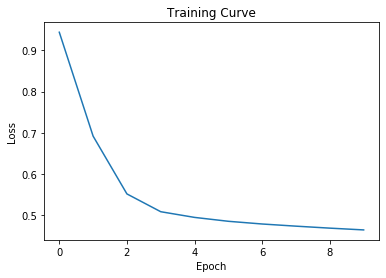

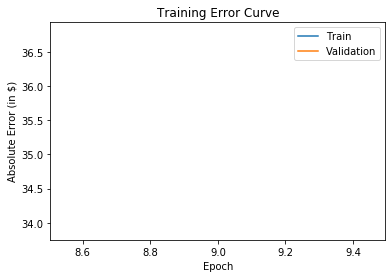

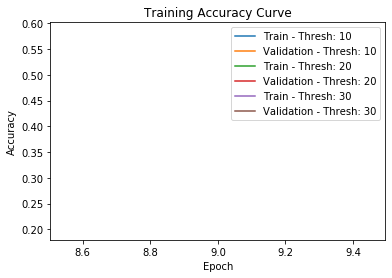

---[ITER 10] loss: 0.459667  time: 2.679
[EPOCH 11] loss: 0.459667  time: 2.691
---[ITER 10] loss: 0.455727  time: 2.627
[EPOCH 12] loss: 0.455727  time: 2.640
---[ITER 10] loss: 0.451908  time: 2.637
[EPOCH 13] loss: 0.451908  time: 2.651
---[ITER 10] loss: 0.448297  time: 3.693
[EPOCH 14] loss: 0.448297  time: 3.709


RuntimeError: DataLoader worker (pid 98636) is killed by signal: Unknown signal: 0. 

In [10]:
net = airbnb_net()

path = os.getcwd() # get current path
path = path[:-5]+"test/Brian/"
now = datetime.datetime.now()
date = now.strftime("%b").lower()+now.strftime("%d")
i = 1

while True:
    try:
        rootdir = path+"/"+date+"_test"+'{:02d}'.format(i)
        os.mkdir(rootdir)
        break
    except:
        i += 1
        
os.mkdir(rootdir+'/lossplot')
os.mkdir(rootdir+'/checkpoint')
os.mkdir(rootdir+'/accplot')
os.mkdir(rootdir+'/errorplot')
os.mkdir(rootdir+'/final')

torch.manual_seed(1)
train(net, train_loader, val_loader, rootdir, lr = 0.001, num_epoch = 1000)